In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 8.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt  # plot

SEED = 11
keras.utils.set_random_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Mounted Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**GetData**

In [ ]:
!unzip /content/drive/MyDrive/project2VDT/sourceCode/data.zip -d /

In [ ]:
import os
def countFile(link):
    path = link
    num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

    print("Number of files in directory: ", num_files)

In [ ]:
countFile("/content/data/happy")
countFile("/content/data/sad")

Number of files in directory:  6906
Number of files in directory:  4912


**Construct dataset**

In [22]:
import cv2
import numpy as np
from keras.utils import to_categorical
import os
import pandas as pd

In [13]:
INPUT_PATH = '/content/data'
EMOTIONS = ["happy","sad"]
IMAGE_SIZE = (96, 96)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [24]:
X, y = load_images(INPUT_PATH,EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape

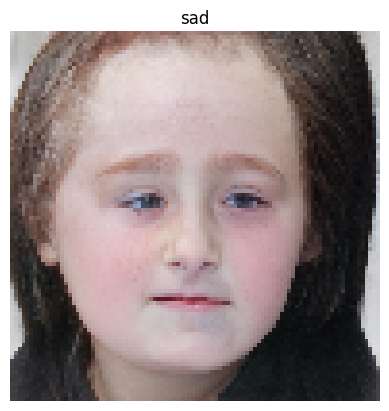

In [25]:
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[y[idx]])
plt.axis('off')  # remove the grid
plt.show()

**Util Function**

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.activations import gelu
import numpy as np
from keras import backend as K

#Patch image to subimage (adapt with input of visionTransformer)
class Patches(layers.Layer):
    def __init__(self,patch_size):
        super(Patches,self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1,self.patch_size,self.patch_size,1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size,-1,patch_dims])
        # print("hehe:, ",patches.shape)
        return patches
        
def get_angle(pos, i, d_model):
    indices = i // 2
    angle_rates = 1 / np.power(10000,(2*indices) / np.float32(d_model))
    
    return pos * angle_rates
    
def pos_encoding(pos,d_model):
    angle_rads = get_angle(np.arange(pos)[:,np.newaxis],
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(angle_rads, dtype=tf.float32)

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder,self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = pos_encoding(pos = num_patches, d_model = projection_dim)

    def call(self, patch):
        length = tf.shape(patch)[1]
        # print("debug1 ",self.projection(patch).shape)
        # print("debug2 ",self.position_embedding.shape)
        encoded = self.projection(patch) + self.position_embedding
        return encoded

class RandomSampling(layers.Layer):
    def __init__(self, num_patches, mask_ratio=0.75):
        super(RandomSampling,self).__init__()
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio
        
        self.num_mask = int(mask_ratio * num_patches)
        self.un_masked_indices = None
        self.masked_indices = None
    
    def get_indices(self):
        return [self.masked_indices, self.un_masked_indices]
    
    def call(self, patches):
        self.masked_indices = np.random.choice(self.num_patches, size=self.num_mask, replace=False)
        self.un_masked_indices = np.delete(np.array(range(self.num_patches)), self.masked_indices)
        
        return tf.gather(patches, self.un_masked_indices, axis=1), self.masked_indices, self.un_masked_indices

class MaskToken(layers.Layer):
    def __init__(self):
        super(MaskToken,self).__init__()
        self.mask_indices = None
        self.un_masked_indices = None
        self.indices = None
        self.mst = None
        self.hidden_size = None
    
    def build(self, input_shape):
        self.hidden_size = input_shape[-1]
        self.mst = tf.Variable(
            name="mst",
            initial_value = tf.random.normal(
                shape=(1, 1, self.hidden_size), dtype='float32'), 
            trainable=True
        )

    def call(self, inputs, mask_indices, un_masked_indices):
        self.mask_indices = mask_indices
        self.un_masked_indices = un_masked_indices
                
        batch_size = tf.shape(inputs)[0]
        mask_num = self.mask_indices.shape[0]
        #update for bach_size
        mst_broadcasted = tf.cast(
                            tf.broadcast_to(self.mst, [batch_size, mask_num, self.hidden_size]),
                            dtype=inputs.dtype,
                        )
        self.indices = tf.concat([self.mask_indices, self.un_masked_indices], axis=0)
        updates = tf.concat([mst_broadcasted, inputs], axis=1)
        out = tf.gather(updates, self.indices, axis=1, batch_dims=0)
        return out

class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, mlp_dim, dropout):
        super(TransformerBlock,self).__init__()
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadAttention(
            num_heads = self.num_heads,
            key_dim = input_shape[-1] // self.num_heads #d_model is input_shape[-1]
        )
        
        self.mlpBlock = Sequential([
            Dense(self.mlp_dim,activation="linear"),
            Lambda(lambda x : gelu(x, approximate=False)),
            Dropout(self.dropout),
            Dense(input_shape[-1]),
            Dropout(self.dropout),
        ])
        
        self.layerNorm1 = LayerNormalization(epsilon = 1e-6)
        self.layerNorm2 = LayerNormalization(epsilon = 1e-6)
        self.layerDropout = Dropout(self.dropout)
    
    def call(self, inputs, training):
        # queries = [
        #     inputs[:, 0:85, 0:21],  # Left eye
        #     inputs[:, 0:85, 43:64],  # Right eye
        #     inputs[:, 85:170, 22:43],  # Nose
        #     inputs[:, 171:256, 22:43]   # Mouth
        # ]
        # for q in queries:

        x = self.att(inputs,inputs)
        x = self.layerDropout(x, training = training)
        x = x + inputs
        y = self.layerNorm2(x)
        y = self.mlpBlock(y)
        x = x + y
        x = self.layerNorm1(x)
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units = units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

**train, val, test split**

In [26]:
id_pos = np.where(y == 1)[0]
id_neg = np.where(y == 0)[0]

np.random.shuffle(id_pos)
np.random.shuffle(id_neg)

id_train_neg = id_neg[:int(len(id_neg) * 0.7)]
id_train_pos = id_pos[:int(len(id_pos) * 0.7)]
id_train = np.concatenate((id_train_neg, id_train_pos), axis = 0)

id_val_neg = id_neg[int(len(id_neg) * 0.7):int(len(id_neg) * 0.9)]
id_val_pos = id_pos[int(len(id_pos) * 0.7):int(len(id_pos) * 0.9)]
id_val = np.concatenate((id_val_neg, id_val_pos), axis = 0)

id_test_neg = id_neg[int(len(id_neg) * 0.9):]
id_test_pos = id_pos[int(len(id_pos) * 0.9):]
id_test = np.concatenate((id_test_neg, id_test_pos), axis = 0)

In [27]:
#train
x_train = X[id_train]
y_train = y[id_train]
#val
x_val = X[id_val]
y_val = y[id_val]
#test
x_test = X[id_test]
y_test = y[id_test]

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
y_train = to_categorical(y_train,dtype = 'int32')
y_val = to_categorical(y_val,dtype = 'int32')
y_test = to_categorical(y_test,dtype = 'int32')

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8272, 96, 96, 3) - y_train shape: (8272, 2)
x_val shape: (2363, 96, 96, 3) - y_val shape: (2363, 2)
x_test shape: (1183, 96, 96, 3) - y_test shape: (1183, 2)


**Hyperparam**

In [10]:
input_shape = (96,96,3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 96  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
drop_out = 0.1
num_class = 2
SEED = 11

**Augmentation**

In [28]:
data_augmentation = Sequential([
    layers.Normalization(),
    layers.RandomCrop(92, 92, seed=SEED, input_shape=input_shape),
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
], name="data_augmentation_layer")

data_augmentation.layers[0].adapt(x_train)

**Create model**

In [29]:
def vit_model():
    inputs = layers.Input(input_shape)
    augmented = data_augmentation(inputs)
    # print(augmented.shape)
    patches = Patches(patch_size)(augmented)
    x = PatchEncoder(num_patches,projection_dim)(patches)
    # print("first: ",x.shape)
    # mat_trai = x[:, 21:85, 0:21]
    # mat_phai = x[:, 21:85, 43:64]
    # mui = x[:, 107:171, 22:43]
    # mieng = x[:, 171:235, 22:43]
    for _ in range(transformer_layers):
         x = TransformerBlock(num_heads=num_heads, mlp_dim=projection_dim * 2, dropout=drop_out) (x) 
    # print("second: ",x.shape)
    # dim_k = 64
    # dim_v = 64
    # dense_q = tf.keras.layers.Dense(units=dim_k)
    # dense_k = tf.keras.layers.Dense(units=dim_k)
    # dense_v = tf.keras.layers.Dense(units=dim_v)
    # print(dense_q(mat_trai).shape)


    # query = [
    #     dense_q(mat_trai), dense_q(mat_phai), dense_q(mui), dense_q(mieng)
    # ]
    # for q in query:

    # queries = tf.concat([dense_q(mat_trai), dense_q(mat_phai), dense_q(mui), dense_q(mieng)], axis = 1)
    # print(queries.shape)
    # keys = dense_k(x)
    # # print(keys.shape)
    # values = dense_v(x)
    # # print(values.shape)

    # cross_attention_output = layers.MultiHeadAttention(
    #     num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    # )(query=queries, value=values, key=keys)
    # print(cross_attention_output.shape)
    # print(cross_attention_output)
    # print(x.shape)
    # x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    # print(x.shape)
    # Add MLP.
    features = mlp(x, hidden_units=mlp_head_units, dropout_rate=0.2)
    logits = layers.Dense(num_class, activation = "softmax")(features)
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

**Optimizer**

In [ ]:
def run_experiment(model,name):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            tfa.metrics.F1Score(num_classes=2)
        ],
    )

    checkpoint_filepath = f"/content/tmp/{name}/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data = (x_val,y_val),
        callbacks=[checkpoint_callback,callback],
    )


    model.load_weights(checkpoint_filepath)
    _, accuracy, f1_score_res = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print("f1_score: ", f1_score_res)

    return history

In [ ]:
vit_classifier = vit_model() 
history = run_experiment(vit_classifier,"vit")

(None, 96, 96, 3)
first:  (None, 256, 64)
second:  (None, 256, 64)
(None, 64, 64)
(None, 256, 64)
(None, 256, 64)
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 64), dtype=tf.float32, name=None), name='multi_head_attention_9/attention_output/add:0', description="created by layer 'multi_head_attention_9'")
Epoch 1/100


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f24fcfa2ef0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


33/33 [==============================] - 62s 735ms/step - loss: 12.3926 - accuracy: 0.5057 - f1_score: 0.4950 - val_loss: 0.6859 - val_accuracy: 0.5844 - val_f1_score: 0.3689
Epoch 2/100
12/33 [=========>....................] - ETA: 11s - loss: 0.7809 - accuracy: 0.5140 - f1_score: 0.4919

KeyboardInterrupt: ignored

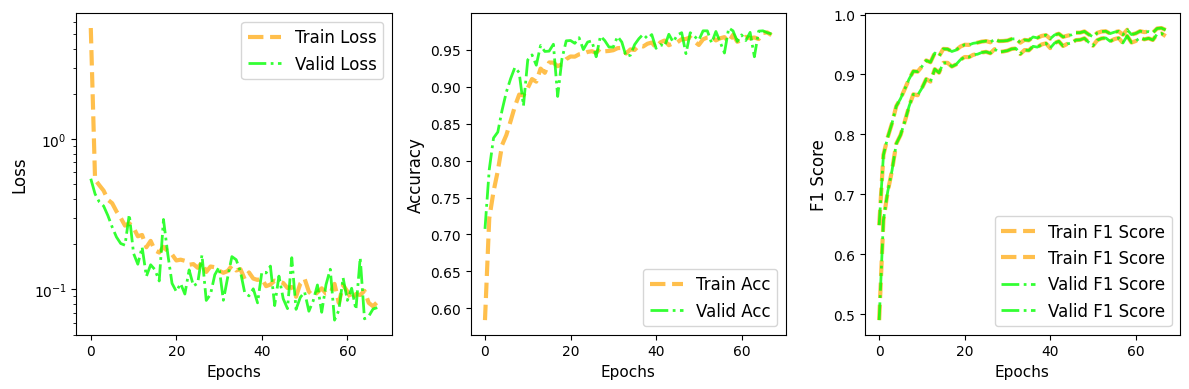

In [ ]:
### Plot train and validation curves
history = history.history
loss = history['loss']
v_loss = history['val_loss']

acc = history['accuracy'] 
v_acc = history['val_accuracy']

f1_score = history['f1_score']
val_f1_score = history['f1_score']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train F1 Score')
plt.plot(epochs, val_f1_score, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid F1 Score') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
vit_classifier.save_weights("/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/VIT_aug/VIT_aug")

In [30]:
vit_classifier = vit_model() 

In [31]:
vit_classifier.load_weights('/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/VIT_aug/VIT_aug')

In [32]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
)

vit_classifier.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tfa.metrics.F1Score(num_classes=2)
    ],
)

vit_classifier.evaluate(x_test, y_test)

37/37 [==============================] - 6s 33ms/step - loss: 0.0540 - accuracy: 0.9822 - f1_score: 0.9817


[0.05402980372309685,
 0.9822485446929932,
 array([0.9848812, 0.9785056], dtype=float32)]

**Inference Dataset**

37/37 [==============================] - 3s 38ms/step
GROUND TRUTH: 
Label 1:  1183
Label 0:  1183
PREDICTION: 
Label 1:  1183
Label 0:  1183


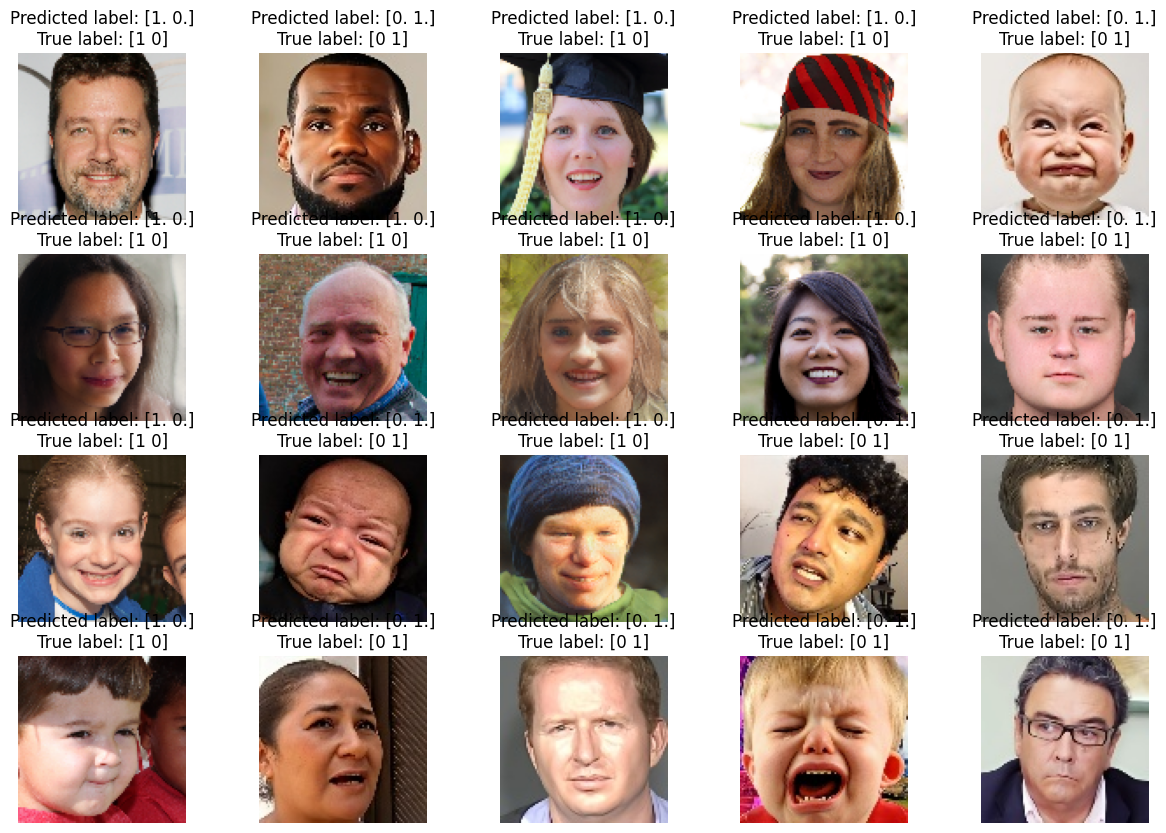

In [33]:
# use model to predict and plot the result
y_pred = vit_classifier.predict(x_test)
y_pred = np.round(y_pred)

print("GROUND TRUTH: ")
print(f"Label 1: ", np.count_nonzero(y_test == 1))
print(f"Label 0: ", np.count_nonzero(y_test == 0))


print("PREDICTION: ")
print(f"Label 1: ", np.count_nonzero(y_pred == 1))
print(f"Label 0: ", np.count_nonzero(y_pred == 0))

# plot random 20 x_test and their predicted labels and ground truth labels
fig, axs = plt.subplots(4, 5, figsize=(15, 10))
for i in range(20):
    ax = axs[i//5, i%5]
    index = np.random.randint(0, len(x_test))
    ax.imshow(x_test[index])
    ax.set_title(f"Predicted label: {y_pred[index]}\nTrue label: {y_test[index]}")
    ax.axis('off')

In [39]:
INPUT_PATH = '/content/drive/MyDrive/project2VDT/sourceCode/InferenceData'
EMOTIONS = ["happy","sad"]
IMAGE_SIZE = (96, 96)

X, y = load_images(INPUT_PATH,EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape

1/1 [==============================] - 0s 127ms/step
GROUND TRUTH: 
Label 1:  22
Label 0:  22
PREDICTION: 
Label 1:  12
Label 0:  32


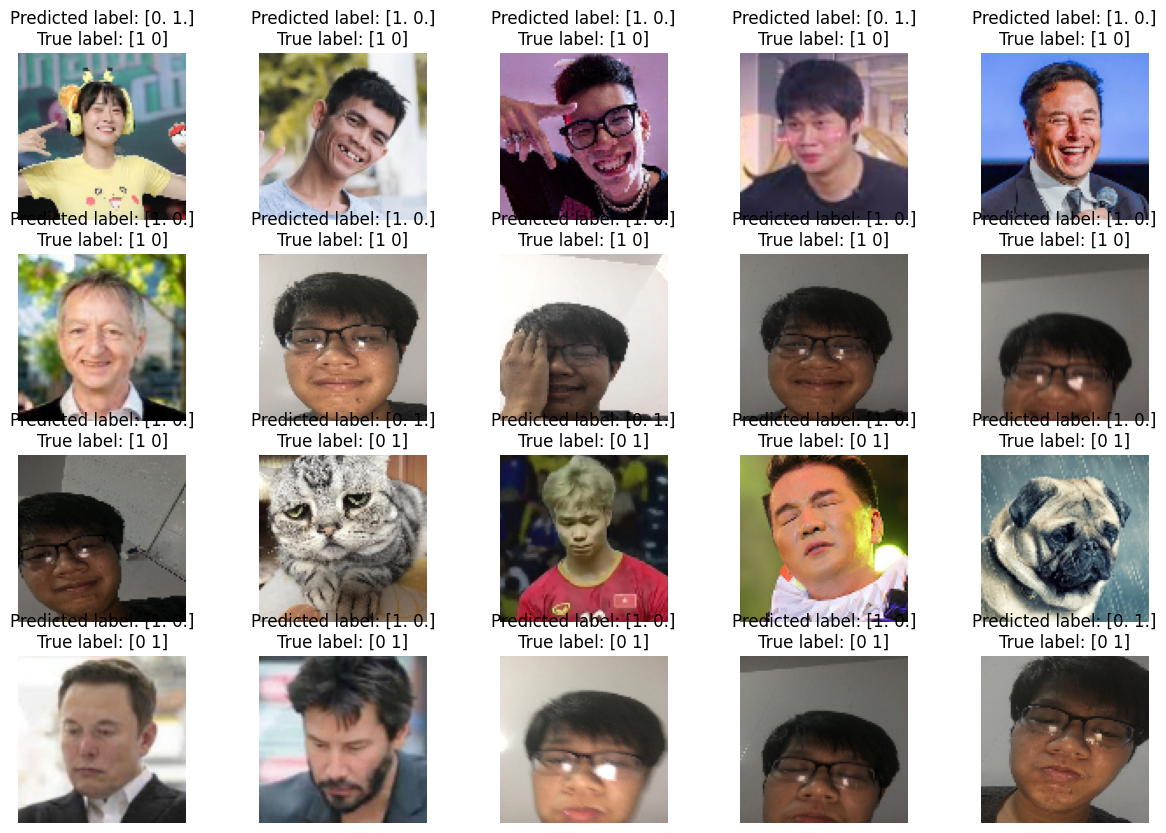

In [40]:
# use model to predict and plot the result
y_infer = vit_classifier.predict(X)
y_infer = np.round(y_infer)
y = y.reshape((-1, 1))
y = to_categorical(y,dtype = 'int32')

print("GROUND TRUTH: ")
print(f"Label 1: ", np.count_nonzero(y == [0,1]))
print(f"Label 0: ", np.count_nonzero(y == [1,0]))


print("PREDICTION: ")
print(f"Label 1: ", np.count_nonzero(y_infer == [0,1]))
print(f"Label 0: ", np.count_nonzero(y_infer == [1,0]))


# plot random 20 x_test and their predicted labels and ground truth labels
fig, axs = plt.subplots(4, 5, figsize=(15, 10))
for i in range(20):
    ax = axs[i//5, i%5]
    ax.imshow(X[i])
    ax.set_title(f"Predicted label: {y_infer[i]}\nTrue label: {y[i]}")
    ax.axis('off')